In [1]:
import os

import yaml
from datasets import load_dataset
from dotenv import load_dotenv
from roboflow import Roboflow

load_dotenv()  # load environment variables stored in .env file (e.g., API keys)

# Useful constants
CURRENT_DIR = os.getcwd()
DATASETS_DIR = os.path.join(CURRENT_DIR, "data")

# Useful functions


def load_config(config_path: str) -> dict:
    """Loads a YAML config file."""
    with open(config_path, "r") as file:
        return yaml.safe_load(file)


def to_path(*args):
    """Converts a list of strings into a path, from the current directory saved in `CURRENT_DIR`."""
    # If "/" is present in one of the strings, it is separated into a list of strings, such that we
    # use the safe `os.path.join` function.
    path_parts = []
    for arg in args:
        if "/" in arg:
            path_parts.extend(arg.split("/"))
        else:
            path_parts.append(arg)

    return os.path.join(CURRENT_DIR, *path_parts)


def download_from(config: dict) -> None:
    """Downloads a dataset using the loaded `config`. It must have the following structure:

    ```
    data:
        dataset: e.g., "guitar-necks-detector" or "dduka/guitar-chords" # The name of the dataset
        load:
            interface: "roboflow" or "datasets"
            # (These must be available only if interface is "roboflow":)
            workspace: "..."
            project-version: "1"
            version-download: "..."
    ```
    """
    if config["data"]["load"]["interface"] == "roboflow":
        # Test if a ROBOFLOW_API_KEY is available
        if not os.getenv("ROBOFLOW_API_KEY"):
            from importlib.util import find_spec

            if find_spec("google"):
                from google.colab import userdata

                if userdata.get("ROBOFLOW_API_KEY"):
                    os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
            else:
                raise ValueError(
                    "ROBOFLOW_API_KEY is not available in the environment variables. "
                    + "Create a .env file in this directory with the key or in Google "
                    + "Colab, add it to secret keys."
                )

        # Initialize Roboflow
        rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))

        # Access the workspace and project
        project = rf.workspace(config["data"]["load"]["workspace"]).project(
            config["data"]["dataset"]
        )
        version = project.version(config["data"]["load"]["project-version"])
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = version.download(config["data"]["load"]["version-download"], location=dataset_path)
    elif config["data"]["load"]["interface"] == "datasets":
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = load_dataset(config["data"]["dataset"], cache_dir=dataset_path)

    return ds, dataset_path

/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FINAL_MODELS_DIR = to_path("final_models")
ORIGINAL_MODELS_DIR = to_path("original_models")
IMAGES_DIR = to_path("images")

In [3]:
f_run_config = "config-yolo-v9.yml"

In [4]:
# Load configuration
config = load_config(to_path(f_run_config))

## **Download Fretboard Dataset**

In [5]:
# Load the ds
dataset, dataset_path = download_from(config)

loading Roboflow workspace...
loading Roboflow project...


## **Append labels and images to COCO dataset**

In [6]:
# Dataset name
DATASET_NAME = config["data"]["dataset"]

# Define the path to the images folder
images_folder = os.path.join(DATASETS_DIR, DATASET_NAME, "valid", "images")

# Create a list to store the formatted image paths
formatted_paths = []

# Iterate through all files in the images folder
for filename in os.listdir(images_folder):
    # Check if the file is an image (you can add more extensions if needed)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        # Format the path as requested
        formatted_path = f"./images/val2017/{filename}"
        formatted_paths.append(formatted_path)

# Define the output file name
output_file = to_path("image_paths.txt")

# Write the formatted paths to the output file
with open(output_file, "w") as f:
    for path in formatted_paths:
        f.write(f"{path}\n")

print(f"Image paths have been written to {output_file}")

Image paths have been written to /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/image_paths.txt


Copy/Paste the resulting txt file `image_paths.txt` in the `val2017.txt` file of the COCO dataset.

In [7]:
import json
import os
from datetime import datetime

def get_bbox_from_label(label_path):
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()
    if len(line) >= 5:  # Ensure we have enough values
        # YOLO format is: class x_center y_center width height
        # We need to convert to COCO format: x_min, y_min, width, height
        x_center, y_center, width, height = map(float, line[1:5])
        x_min = (x_center - width / 2) * 640  # Assuming 640x640 image
        y_min = (y_center - height / 2) * 640
        width *= 640
        height *= 640
        return [x_min, y_min, width, height]
    return [0, 0, 0, 0]  # Default if parsing fails

def update_annotations(original_json_path, image_paths_txt, new_json_path, labels_folder):
    # Load the original JSON file
    with open(original_json_path, 'r') as f:
        data = json.load(f)
    
    # Load image paths from the text file
    with open(image_paths_txt, 'r') as f:
        new_image_paths = f.read().splitlines()
    
    # Get the highest existing image and annotation IDs
    max_image_id = max(image['id'] for image in data['images']) if data['images'] else 0
    max_annotation_id = max(ann['id'] for ann in data['annotations']) if data['annotations'] else 0
    
    # Process new images
    for i, path in enumerate(new_image_paths, start=1):
        file_name = os.path.basename(path)
        label_name = os.path.splitext(file_name)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_name)
        
        # Create new image entry
        new_image = {
            "license": 1,  # Assuming a default license
            "file_name": file_name,
            "coco_url": f"http://images.cocodataset.org/val2017/{file_name}",
            "height": 640,  # Placeholder, you might want to get actual dimensions
            "width": 640,   # Placeholder, you might want to get actual dimensions
            "date_captured": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "flickr_url": "",  # Leave empty if not applicable
            "id": max_image_id + i
        }
        data['images'].append(new_image)
        
        # Get bbox from label file
        bbox = get_bbox_from_label(label_path)
        
        # Create annotation for each new image
        new_annotation = {
            "segmentation": [],  # Empty for now, as we don't have segmentation data
            "area": bbox[2] * bbox[3],  # width * height
            "iscrowd": 0,
            "image_id": new_image['id'],
            "bbox": bbox,
            "category_id": 91,  # Assuming all new images are fretboards
            "id": max_annotation_id + i
        }
        data['annotations'].append(new_annotation)
    
    # Save the updated JSON
    with open(new_json_path, 'w') as f:
        json.dump(data, f, indent=4)
    
    print(f"Updated annotations saved to {new_json_path}")

# Usage
original_json_path = '/home/camilo/Repositorios/datasets/coco-with-fretboard/annotations/instances_val2017.json'
image_paths_txt = 'image_paths.txt'
new_json_path = '/home/camilo/Repositorios/datasets/coco-with-fretboard/annotations/updated_annotations.json'
labels_folder = os.path.join(DATASETS_DIR, config["data"]["dataset"], "valid", "labels")
# labels_folder = './labels/val2017'  # Adjust this path as needed

update_annotations(original_json_path, image_paths_txt, new_json_path, labels_folder)

Updated annotations saved to /home/camilo/Repositorios/datasets/coco-with-fretboard/annotations/updated_annotations.json


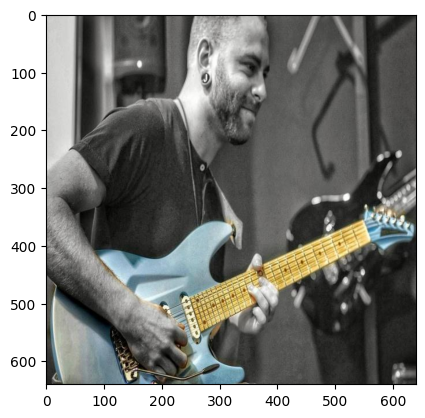

In [8]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Load one image from the dataset from the validation set
image_path = os.path.join(
    DATASETS_DIR,
    config["data"]["dataset"],
    "valid",
    "images",
    "00bd37ba0766e253cc82e587b9d1aee2_jpg.rf.d004201156494166fc5d249b393d4aaa.jpg",
)

# Load the image
image = plt.imread(image_path)

# Display the image
plt.imshow(image)

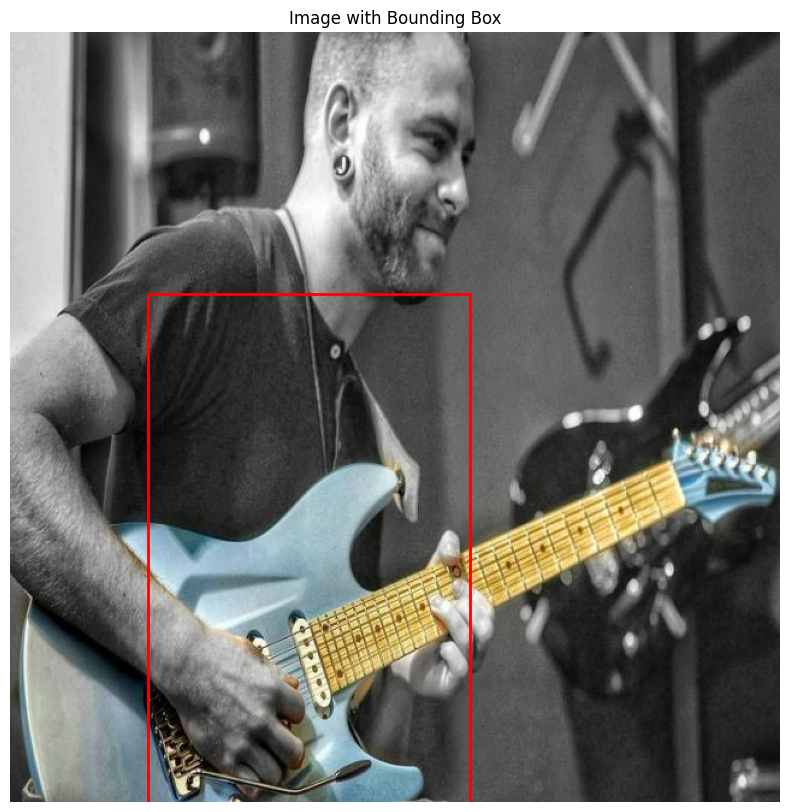

In [9]:
# Get the labels from the corresponding txt and display them
labels_path = image_path.replace("images", "labels").replace(".jpg", ".txt")


def get_bbox_from_label(label_path):
    with open(label_path, "r") as f:
        line = f.readline().strip().split()
    if len(line) >= 5:  # Ensure we have enough values
        # YOLO format is: class x_center y_center width height
        # We need to convert to COCO format: x_min, y_min, width, height
        x_center, y_center, width, height = map(float, line[1:5])
        x_min = (x_center - width / 2) * 640  # Assuming 640x640 image
        y_min = (y_center - height / 2) * 640
        width *= 640
        height *= 640
        return [x_min, y_min, width, height]
    return [0, 0, 0, 0]  # Default if parsing fails


# Get the bounding box from the label
bbox = get_bbox_from_label(labels_path)

# Display the bounding box on top of the image
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
plt.gca().add_patch(rect)

plt.axis('off')  # Turn off axis labels
plt.title('Image with Bounding Box')
plt.show()